## Global Warming 

### Imports

In [1]:
import ultranest
import george 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ultranest.plot import cornerplot

### Reading the Data

In [2]:
# Read the data
df = pd.read_csv('GlobalTempData.txt', comment="%", sep='\s+',header=None,)

# Keep only the first two columns
df = df.iloc[:, :3]

# Rename columns
df.columns = ["Year", "Annual_Anomaly", "Annual_Anomaly_Error"]

# Save the data in arrays
year = np.array( df["Year"])
temp = np.array( df["Annual_Anomaly"])
temp_err = np.array( df["Annual_Anomaly_Error"])

df

,Year,Annual_Anomaly,Annual_Anomaly_Error
0,1850,-0.436,0.170
1,1851,-0.321,0.259
2,1852,-0.292,0.249
3,1853,-0.295,0.196
4,1854,-0.283,0.130
...,...,...,...
170,2020,1.049,0.032
171,2021,0.895,0.030
172,2022,0.936,0.031
173,2023,1.229,0.031


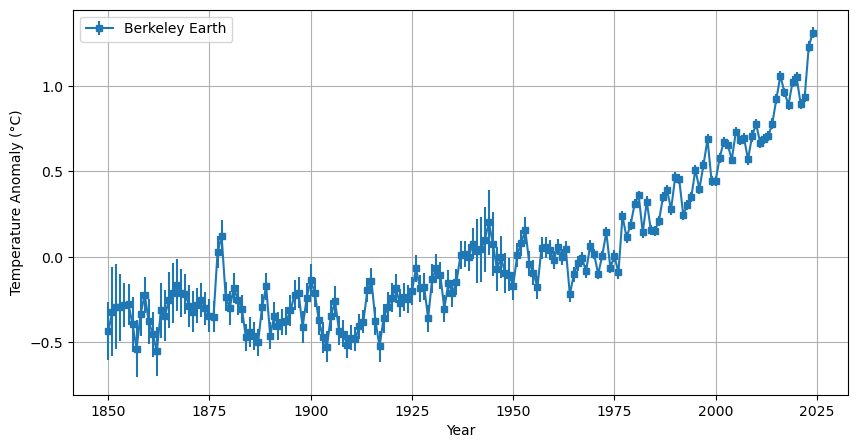

In [3]:
plt.figure(figsize=(10, 5))
plt.errorbar( df['Year'], df['Annual_Anomaly'], df['Annual_Anomaly_Error'], label='Berkeley Earth', fmt='s',  markersize= 5, linestyle= "-")
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()

### Models

* Constant Temperature (const): $\Delta T(y) = K$ ,
* Linear Temperature (lin): $\Delta T(y) = a y + b$ ,
* Exponential Temperature (exp): $\Delta T(y) = c \; e^{d y} + e$ ,

where $\Delta T$ is the temperature anomaly and $y$ is the year.

#### definitions

In [4]:
#====================================================================================
# Constants
const_params = ['k']            #constant temperature
lin_params = ['a', 'b']         #linear temperature
exp_params = ['c', 'd', 'e']    #exponential temperature


#====================================================================================
# Log_likelihoods

#constant 
def const_loglikelihood(params):
    (k) = params
    log_like = -np.sum(((temp - k)/temp_err)**2 + np.log(2*np.pi*temp_err**2)) / 2 
    return log_like

#linear
def lin_loglikelihood(params):
    (a, b) = params
    pred = a*(year - 1937) + b
    log_like = -np.sum(((temp - pred)/temp_err)**2 + np.log(2*np.pi*temp_err**2)) / 2 
    return log_like

#exponential
def exp_loglikelihood(params):
    (c, d, e) = params
    pred = c * np.exp(d * (year - 1937)) + e
    log_like = -np.sum(((temp - pred)/temp_err)**2 + np.log(2*np.pi*temp_err**2)) / 2 
    return log_like


#====================================================================================
# Flat priors

#constant
def const_prior(u):
    params = u.copy()
    hi = 2
    lo = -2
    params[0] = lo + (hi-lo)*u[0]
    return params

#linear
def lin_prior(u):
    params = u.copy()
    hi = [0.05, 2]
    lo = [-0.05, -2]
    for i in range(len(hi)):
        params[i] = lo[i] + (hi[i]-lo[i])*u[i]
    
    return params

#exponential
def exp_prior(u):
    params = u.copy()
    hi = [1, 0.5, 1.]
    lo = [-1, 0., -1.]
    for i in range(len(hi)):
        params[i] = lo[i] + (hi[i]-lo[i])*u[i]
    
    return params

In [5]:
const_sampler = ultranest.ReactiveNestedSampler(const_params, const_loglikelihood, const_prior, log_dir='const_run/', resume=True)
lin_sampler = ultranest.ReactiveNestedSampler(lin_params, lin_loglikelihood, lin_prior, log_dir='lin_run/', resume=True)
exp_sampler = ultranest.ReactiveNestedSampler(exp_params, exp_loglikelihood, exp_prior, log_dir='exp_run/', resume=True)

#### constant temperature anomaly

$$
\Delta T(y) = K \; .
$$

In [6]:
print('\nInference with constant temperature model:\n')
const_result = const_sampler.run(min_num_live_points=1000, viz_callback=None)


Inference with constant temperature model:

[ultranest] Resuming from 10544 stored points
[ultranest] Explored until L=-7e+03  966.31 [-6966.3089..-6966.3089]*| it/evals=9500/10686 eff=inf% N=1000 0  0 
[ultranest] Likelihood function evaluations: 10686
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -6972 +- 0.06705
[ultranest] Effective samples strategy satisfied (ESS = 3128.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.07, need <0.5)
[ultranest]   logZ error budget: single: 0.08 bs:0.07 tail:0.03 total:0.07 required:<0.50
[ultranest] done iterating.


#### linear temperature anomaly

$$
\Delta T(y) = a y + b \; .
$$

In [7]:
print('\nInference with linear temperature model:\n')
lin_result = lin_sampler.run(min_num_live_points=1000, viz_callback=None)


Inference with linear temperature model:

[ultranest] Resuming from 17730 stored points
[ultranest] Explored until L=-1e+03  408.72 [-1408.7337..-1408.7337]*| it/evals=16700/21438 eff=inf% N=1000      
[ultranest] Likelihood function evaluations: 21438
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -1421 +- 0.08395
[ultranest] Effective samples strategy satisfied (ESS = 3981.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.11 bs:0.08 tail:0.01 total:0.08 required:<0.50
[ultranest] done iterating.


#### exponential temperature anomaly

$$
\Delta T(y) = c \; e^{d y} + e \; .
$$

In [8]:
print('\nInference with exponential temperature model:\n')
exp_result = exp_sampler.run(min_num_live_points=1000, viz_callback=None)


Inference with exponential temperature model:

[ultranest] Resuming from 22762 stored points
[ultranest] Explored until L=-1e+02  .32 [-135.3703..-135.3703]*| it/evals=21728/79327 eff=inf% N=1000    0   0 00 0 0 
[ultranest] Likelihood function evaluations: 79327
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -152.5 +- 0.09512
[ultranest] Effective samples strategy satisfied (ESS = 4675.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.13 bs:0.10 tail:0.01 total:0.10 required:<0.50
[ultranest] done iterating.


#### results

In [9]:
print('\nConstant temperature model:')
const_sampler.print_results()
print('\nLinear temperature model:')
lin_sampler.print_results()
print('\nExponential temperature model:')
exp_sampler.print_results()


Constant temperature model:

logZ = -6972.417 +- 0.133
  single instance: logZ = -6972.417 +- 0.075
  bootstrapped   : logZ = -6972.422 +- 0.129
  tail           : logZ = +- 0.032
insert order U test : converged: True correlation: inf iterations

    k                   : 0.3399│ ▁  ▁▁▁▁▁▁▁▂▂▃▄▅▅▆▇▇▇▇▆▆▄▄▃▂▂▁▁▁▁▁▁▁▁▁ │0.3697    0.3552 +- 0.0035


Linear temperature model:

logZ = -1420.852 +- 0.172
  single instance: logZ = -1420.852 +- 0.106
  bootstrapped   : logZ = -1420.871 +- 0.171
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    a                   : 0.009697│ ▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅▆▇▇▇▇▆▆▅▃▃▂▂▁▁▁▁▁▁▁▁ ▁ │0.010533    0.010107 +- 0.000094
    b                   : -0.1138│ ▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆▆▇▇▇▇▆▅▄▃▃▂▂▁▁▁▁▁▁▁  ▁ │-0.0660    -0.0909 +- 0.0054


Exponential temperature model:

logZ = -152.504 +- 0.204
  single instance: logZ = -152.504 +- 0.125
  bootstrapped   : logZ = -152.487 +- 0.204
  tail           : logZ = +- 0.010
insert order

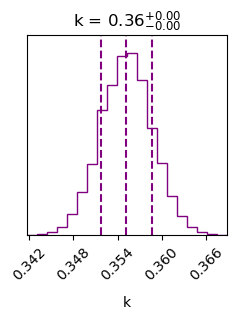

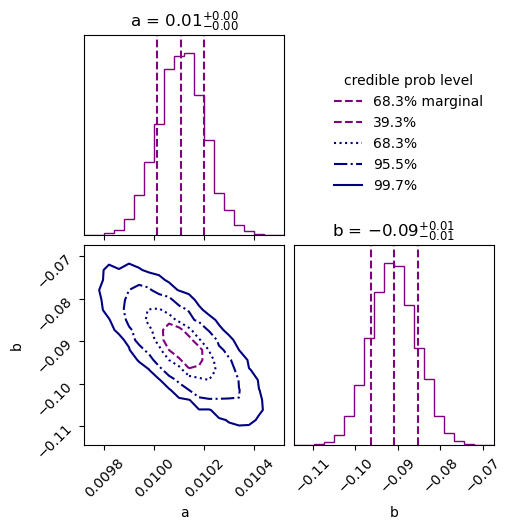

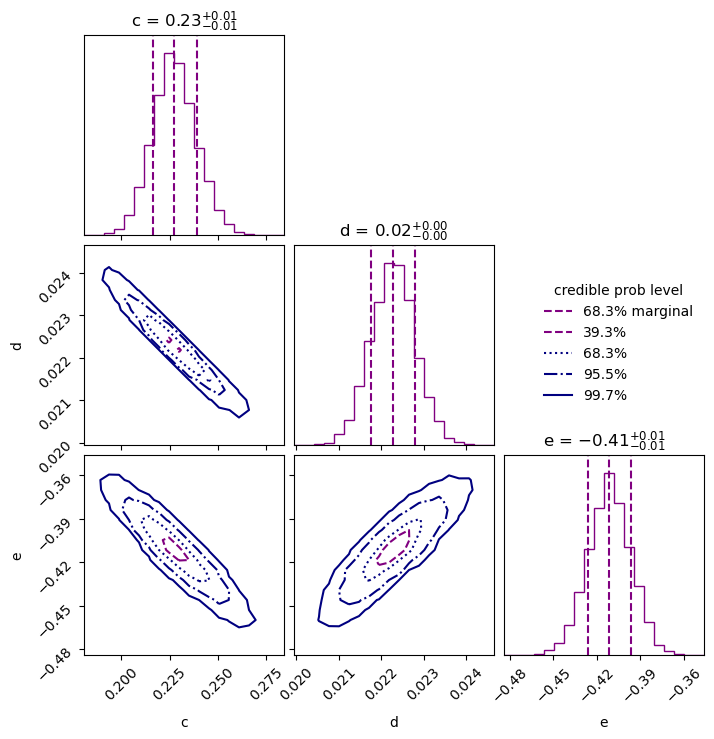

In [10]:
cornerplot(const_result);
cornerplot(lin_result);
cornerplot(exp_result);

#### inferred parameters

In [11]:
#constant temperature
const_samples = const_result["samples"][:, 0] 
k_best = np.median(const_samples)
k_lower_95, k_upper_95 = np.percentile(const_samples, [2.5, 97.5])


#linear temperature
a_lin_samples = lin_result["samples"][:, 0] 
a_best = np.median(a_lin_samples)
a_lower_95, a_upper_95 = np.percentile(a_lin_samples, [2.5, 9.5])

b_lin_samples = lin_result["samples"][:, 1] 
b_best = np.median(b_lin_samples)
b_lower_95, b_upper_95 = np.percentile(b_lin_samples, [2.5, 97.5])

#exponential temperature
c_exp_samples = exp_result["samples"][:, 0] 
c_best = np.median(c_exp_samples)
c_lower_95, c_upper_95 = np.percentile(c_exp_samples, [2.5, 97.5])

d_exp_samples = exp_result["samples"][:, 1] 
d_best = np.median(d_exp_samples)
d_lower_95, d_upper_95 = np.percentile(d_exp_samples, [2.5, 97.5])

e_exp_samples = exp_result["samples"][:, 2] 
e_best = np.median(e_exp_samples)
e_lower_95, e_upper_95 = np.percentile(e_exp_samples, [2.5, 97.5])

# Print the results
print(f"Constant Model of Temperature:\nBest estimate of k: {k_best:.3f}")
print(f"95% Credible Interval: [{k_lower_95:.3f}, {k_upper_95:.3f}]\n")

print(f"Linear Model of Temperature:\nBest estimate of a: {a_best:.3f}")
print(f"95% Credible Interval: [{a_lower_95:.3f}, {a_upper_95:.3f}]")
print(f"Best estimate of b: {b_best:.3f}")
print(f"95% Credible Interval: [{b_lower_95:.3f}, {b_upper_95:.3f}]\n")

print(f"Exponential Model of Temperature:\nBest estimate of c: {c_best:.3f}")
print(f"95% Credible Interval: [{c_lower_95:.3f}, {c_upper_95:.3f}]")
print(f"Best estimate of d: {d_best:.3f}")
print(f"95% Credible Interval: [{d_lower_95:.3f}, {d_upper_95:.3f}]\n")
print(f"Best estimate of e: {e_best:.3f}")
print(f"95% Credible Interval: [{e_lower_95:.3f}, {e_upper_95:.3f}]\n")

Constant Model of Temperature:
Best estimate of k: 0.355
95% Credible Interval: [0.348, 0.362]

Linear Model of Temperature:
Best estimate of a: 0.010
95% Credible Interval: [0.010, 0.010]
Best estimate of b: -0.091
95% Credible Interval: [-0.101, -0.080]

Exponential Model of Temperature:
Best estimate of c: 0.227
95% Credible Interval: [0.206, 0.251]
Best estimate of d: 0.022
95% Credible Interval: [0.021, 0.023]

Best estimate of e: -0.411
95% Credible Interval: [-0.441, -0.383]



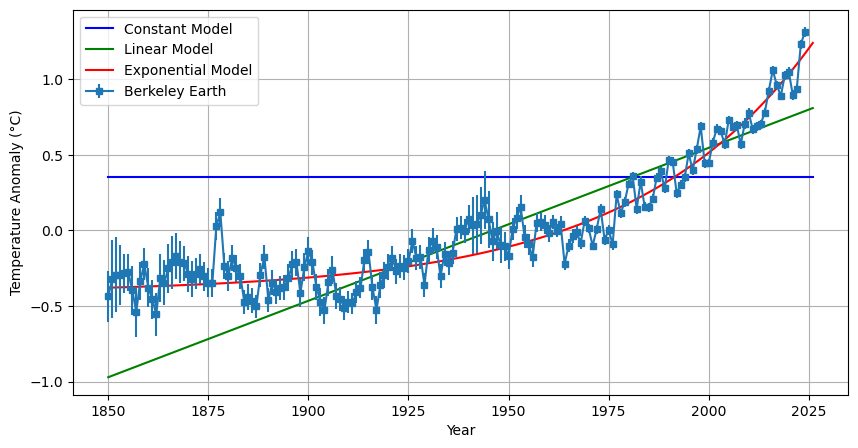

In [12]:
plt.figure(figsize=(10, 5))

# Define x range
x = np.linspace(1850, 2026, 100)  
# Plot the constant function
plt.plot(x, np.full_like(x, k_best), label="Constant Model", color="blue")

# Plot the linear function
plt.plot(x, a_best * (x - 1937) + b_best, label="Linear Model", color="green")

# Plot the exponential function
plt.plot(x, c_best * np.exp(d_best*(x - 1937)) + e_best, label="Exponential Model", color="red")
#plt.fill_between(x, c_lower_95 * np.exp(d_lower_95*(x - 1937)), c_upper_95 * np.exp(d_upper_95*(x - 1937)), label = "95% Credible Interval", color = "yellow")

plt.errorbar( df['Year'], df['Annual_Anomaly'], df['Annual_Anomaly_Error'], label='Berkeley Earth', fmt='s',  markersize= 5, linestyle= "-")
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()

### Gaussian Process Regressions

#### zero mean

The covariance function we're using is the product of the ExpSquaredKernel defined below and the variance of our data:
$$
ExpSquaredKernel(r^2) = e^{-\frac{r^2}{2l^2}} \; ,
$$
so the covariance function is:
$$
K = \sigma_{\Delta T}^2 e^{-\frac{r^2}{2l^2}} \; .
$$

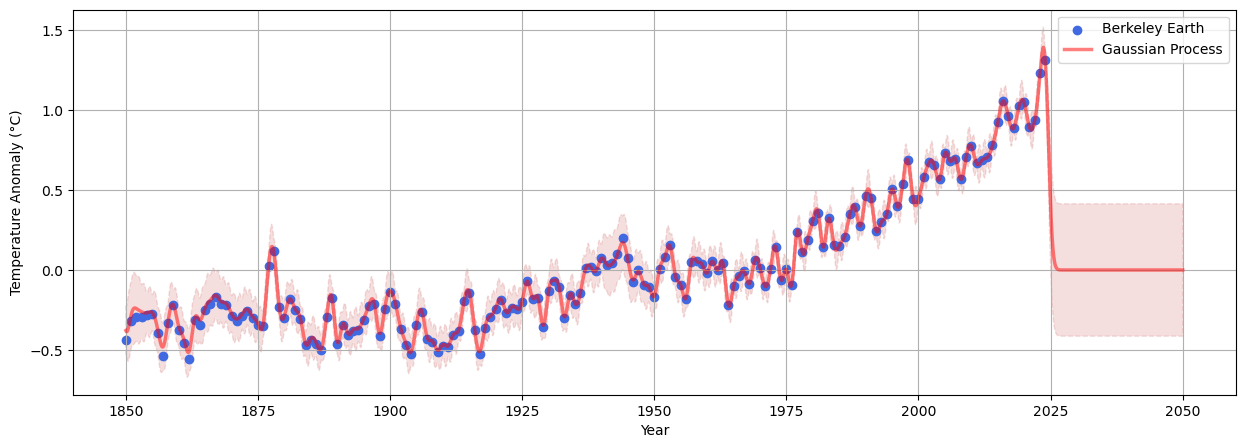

In [13]:
#computation of the Gaussian Process
kernel =  np.var(temp) * george.kernels.ExpSquaredKernel(0.5)   
gp = george.GP(kernel)
gp.compute(year, yerr = temp_err)

#prediction
x_pred = np.linspace(1850, 2050, 10000)
pred, pred_var = gp.predict(temp, x_pred, return_var = True)

#plot
plt.figure(figsize=(15, 5))
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color = "indianred", alpha = 0.2, linestyle = "--")

plt.scatter(year, temp, color = "royalblue", label='Berkeley Earth', linestyle= "-")
plt.plot(x_pred, pred, color = "red", lw = 2.5, alpha = 0.5, label = 'Gaussian Process')
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()

#### GP with trends

Let's now use Gaussian Processes with different trends. We introduce two parameters in the covariance function: $\sigma$ and $l$, so $K(r)$ can be written as:

$$
K(r) = \sigma^2 \; e^{\frac{r^2}{2l^2}} \; .
$$

We then optimize the covariance function's parameters and the trend function ones using ultranest. 

##### GP with constant trend

The constant function ha just one parameter $k$.

In [14]:
const_GP_params = ['sigma', 'l', 'k']

def const_GP_loglikelihood(params):
    (sigma, l, k) = params
    
    kernel = sigma ** 2 * george.kernels.ExpSquaredKernel(1/(2 * l ** 2)) 
    gp = george.GP(kernel)
    gp.compute(year, temp_err)

    zero_mean = temp - k
    
    return gp.log_likelihood(zero_mean)

def const_GP_prior(u):
    params = u.copy()
    hi = [1., 20., 1.]
    lo = [0., 0., -1.]
    for i in range(len(hi)):
        params[i] = lo[i] + (hi[i]-lo[i])*u[i]
    
    return params

In [15]:
const_GP_sampler = ultranest.ReactiveNestedSampler(const_GP_params, const_GP_loglikelihood, const_GP_prior, log_dir='const_gp_run/', resume=True)
const_GP_result = const_GP_sampler.run(min_num_live_points=1000, viz_callback=None)

[ultranest] Resuming from 16883 stored points
[ultranest] Explored until L=3e+01  34.0004..34.0004]*| it/evals=15800/32969 eff=inf% N=1000        0 
[ultranest] Likelihood function evaluations: 32969
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = 22.75 +- 0.09784
[ultranest] Effective samples strategy satisfied (ESS = 4818.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.10 bs:0.10 tail:0.01 total:0.10 required:<0.50
[ultranest] done iterating.


In [16]:
const_GP_sampler.print_results()


logZ = 22.750 +- 0.172
  single instance: logZ = 22.750 +- 0.099
  bootstrapped   : logZ = 22.755 +- 0.172
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    sigma               : 0.250 │ ▁▁▁▁▁▁▂▃▃▄▅▇▇▇▇▇▅▄▄▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ │0.520     0.355 +- 0.030
    l                   : 0.345 │ ▁▁▁▁▁▁▂▃▅▅▇▇▇▇▆▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁ │0.528     0.413 +- 0.020
    k                   : -0.272│ ▁  ▁▁▁▁▁▁▁▁▁▂▃▄▄▆▆▇▇▇▇▆▅▄▃▂▂▁▁▁▁▁▁▁ ▁ │0.279     0.021 +- 0.056



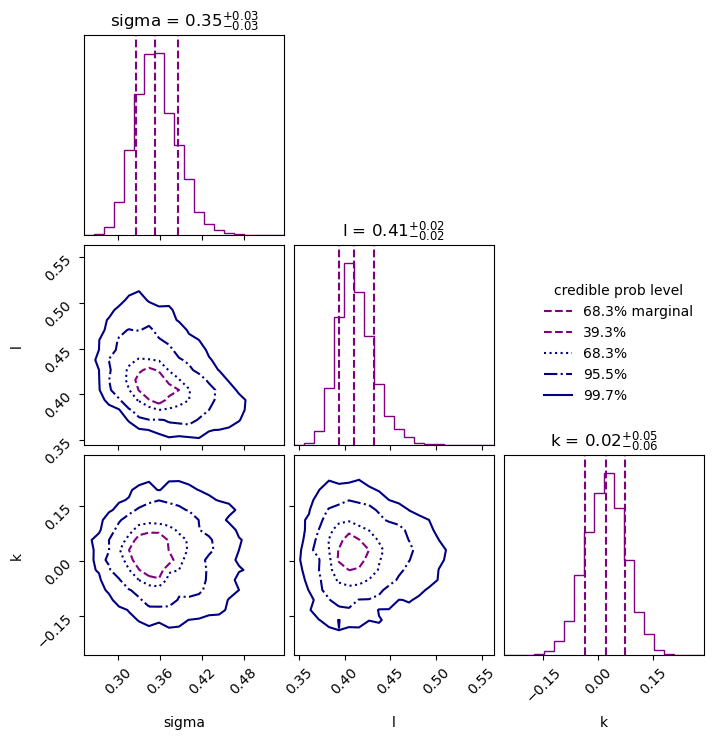

In [17]:
cornerplot(const_GP_result);

In [18]:
const_sigma_samples = const_GP_result["samples"][:, 0] 
const_sigma_best = np.median(const_sigma_samples)

const_l_samples = const_GP_result["samples"][:, 1] 
const_l_best = np.median(const_l_samples)

const_k_samples = const_GP_result["samples"][:, 2] 
const_k_best = np.median(const_k_samples)

const_GP_kernel = const_sigma_best ** 2 * george.kernels.ExpSquaredKernel(1/(2 * const_l_best ** 2)) 
const_GP = george.GP(const_GP_kernel)
const_GP.compute(year, temp_err)



const_GP_pred, const_GP_pred_var = const_GP.predict(temp - const_k_best, x_pred, return_var = True)
const_GP_pred += const_k_best

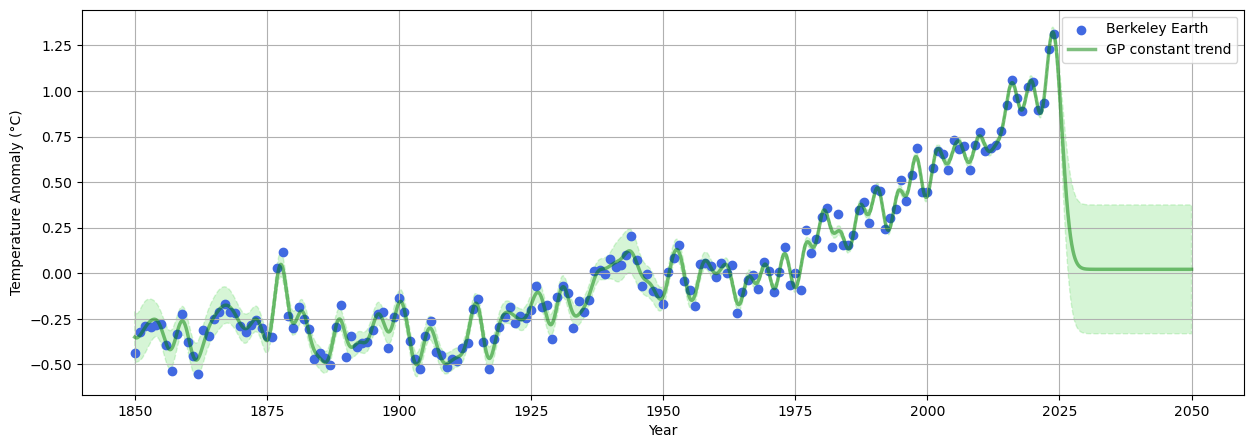

In [19]:
plt.figure(figsize=(15, 5))
# plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color = "indianred", alpha = 0.2, linestyle = "--")
plt.fill_between(x_pred, const_GP_pred - np.sqrt(const_GP_pred_var), const_GP_pred + np.sqrt(const_GP_pred_var), color = "limegreen", alpha = 0.2, linestyle = "--")

plt.scatter(year, temp, color = "royalblue", label='Berkeley Earth', linestyle= "-")
# plt.plot(x_pred, pred, color = "red", lw = 2.5, alpha = 0.5, label = 'GP zero mean')
plt.plot(x_pred, const_GP_pred, color = "green", lw = 2.5, alpha = 0.5, label = 'GP constant trend')
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()

##### GP linear

We have now two parameters for the linear function: $\left(a, b\right)$.

In [20]:
lin_GP_params = ['sigma', 'l', 'a', 'b']

def lin_GP_loglikelihood(params):
    (sigma, l, a, b) = params
    
    kernel = sigma ** 2 * george.kernels.ExpSquaredKernel(1/(2 * l ** 2)) 
    gp = george.GP(kernel)
    gp.compute(year, temp_err)

    zero_mean = temp - (a *  (year - 1937) + b)
    
    return gp.log_likelihood(zero_mean)

def lin_GP_prior(u):
    params = u.copy()
    hi = [1., 20., 0.05, 2.]
    lo = [0., 0., -0.05, -2.]
    for i in range(len(hi)):
        params[i] = lo[i] + (hi[i]-lo[i])*u[i]
    
    return params

In [21]:
lin_GP_sampler = ultranest.ReactiveNestedSampler(lin_GP_params, lin_GP_loglikelihood, lin_GP_prior, log_dir='lin_gp_run/', resume=True)
lin_GP_result = lin_GP_sampler.run(min_num_live_points=1000, viz_callback=None)

[ultranest] Resuming from 22504 stored points
[ultranest] Explored until L=8e+01  80.5576..80.5576]*| it/evals=21500/141280 eff=inf% N=1000    0   000  
[ultranest] Likelihood function evaluations: 141280
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = 63.67 +- 0.108
[ultranest] Effective samples strategy satisfied (ESS = 5545.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.12 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.


In [22]:
lin_GP_sampler.print_results()


logZ = 63.711 +- 0.152
  single instance: logZ = 63.711 +- 0.122
  bootstrapped   : logZ = 63.671 +- 0.152
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    sigma               : 0.134 │ ▁▁▁▁▁▁▂▃▃▅▆▇▇▆▆▆▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁ ▁  ▁ │0.283     0.189 +- 0.014
    l                   : 0.409 │ ▁▁▁▁▁▁▁▁▂▂▂▃▄▅▆▆▇▇▇▆▅▄▃▂▂▁▁▁▁▁▁▁▁   ▁ │0.871     0.621 +- 0.049
    a                   : 0.00518│ ▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆▇▇▇▇▇▇▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁ │0.00958    0.00730 +- 0.00050
    b                   : -0.108│ ▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆▆▇▇▇▆▆▅▄▄▂▂▁▁▁▁▁▁▁▁▁ │0.110     0.007 +- 0.025



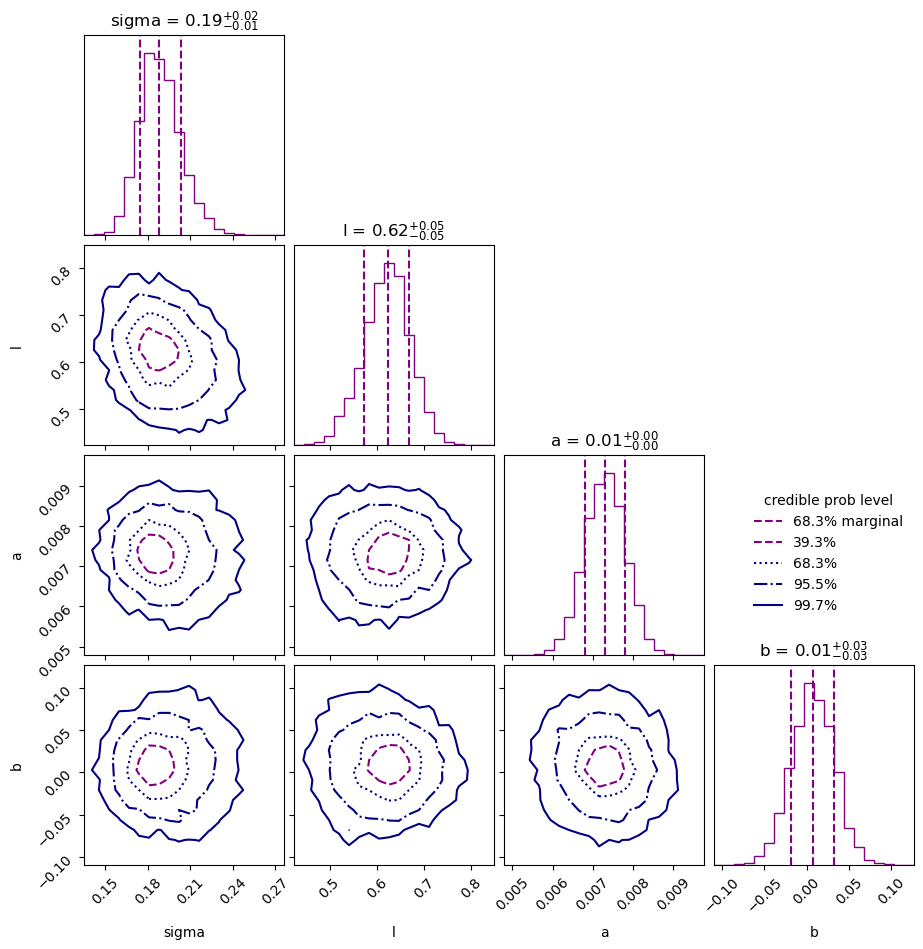

In [23]:
cornerplot(lin_GP_result);

In [24]:
lin_sigma_samples = lin_GP_result["samples"][:, 0] 
lin_sigma_best = np.median(lin_sigma_samples)

lin_l_samples = lin_GP_result["samples"][:, 1] 
lin_l_best = np.median(lin_l_samples)

lin_a_samples = lin_GP_result["samples"][:, 2] 
lin_a_best = np.median(lin_a_samples)

lin_b_samples = lin_GP_result["samples"][:, 3] 
lin_b_best = np.median(lin_b_samples)

def lin_gp_base(year): return lin_a_best *  (year - 1937) + lin_b_best

lin_GP_kernel = lin_sigma_best ** 2 * george.kernels.ExpSquaredKernel(1/(2 * lin_l_best ** 2)) 
lin_GP = george.GP(lin_GP_kernel)
lin_GP.compute(year, temp_err)


lin_GP_pred, lin_GP_pred_var = lin_GP.predict(temp - lin_gp_base(year), x_pred, return_var = True)
lin_GP_pred += lin_gp_base(x_pred)

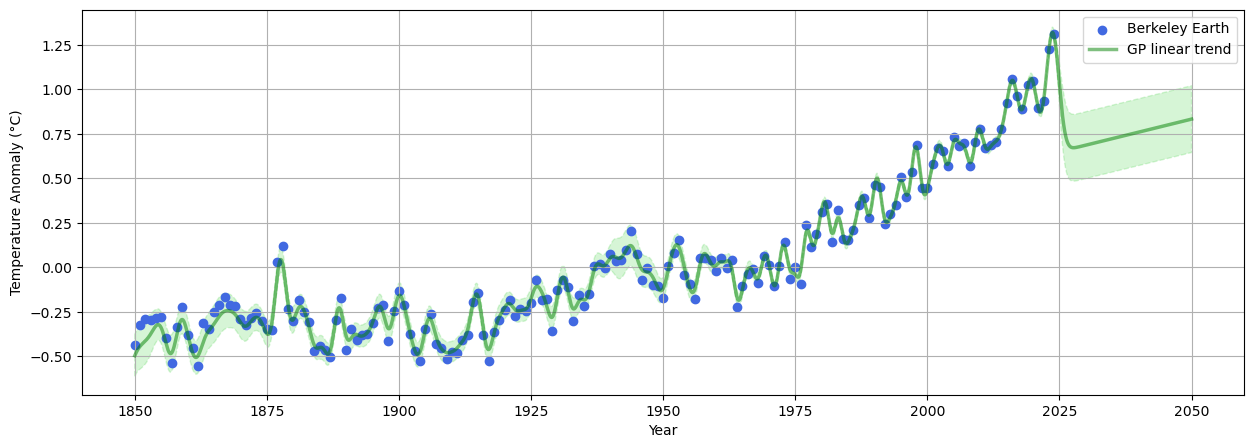

In [25]:
plt.figure(figsize=(15, 5))
# plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color = "indianred", alpha = 0.2, linestyle = "--")
plt.fill_between(x_pred, lin_GP_pred - np.sqrt(lin_GP_pred_var), lin_GP_pred + np.sqrt(lin_GP_pred_var), color = "limegreen", alpha = 0.2, linestyle = "--")

plt.scatter(year, temp, color = "royalblue", label='Berkeley Earth', linestyle= "-")
# plt.plot(x_pred, pred, color = "red", lw = 2.5, alpha = 0.5, label = 'GP zero mean')
plt.plot(x_pred, lin_GP_pred, color = "green", lw = 2.5, alpha = 0.5, label = 'GP linear trend')
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()

#### GP exponential trend

We use three parameters for the exponential function: $\left(c,d,e\right)$.

In [26]:
exp_GP_params = ['sigma', 'l', 'c', 'd', 'e']

def exp_GP_loglikelihood(params):
    (sigma, l, c, d, e) = params
    
    kernel = sigma ** 2 * george.kernels.ExpSquaredKernel(1/(2 * l ** 2)) 
    gp = george.GP(kernel)
    gp.compute(year, temp_err)

    zero_mean = temp - (c * np.exp(d * (year - 1937)) + e)
    
    return gp.log_likelihood(zero_mean)

def exp_GP_prior(u):
    params = u.copy()
    hi = [1., 20., 1., 0.5, 1.]
    lo = [0., 0., -1, 0., -1.]
    for i in range(len(hi)):
        params[i] = lo[i] + (hi[i]-lo[i])*u[i]
    
    return params

In [27]:
exp_GP_sampler = ultranest.ReactiveNestedSampler(exp_GP_params, exp_GP_loglikelihood, exp_GP_prior, log_dir='exp_gp_run/', resume=True)
exp_GP_result = exp_GP_sampler.run(min_num_live_points=1000, viz_callback=None)

[ultranest] Resuming from 27793 stored points
[ultranest] Explored until L=1e+02  6 [131.7834..131.7834]*| it/evals=26700/1238534 eff=inf% N=1000   0 00 0 0 0 
[ultranest] Likelihood function evaluations: 1238534
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = 109.7 +- 0.1107
[ultranest] Effective samples strategy satisfied (ESS = 6044.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.


In [28]:
exp_GP_sampler.print_results()


logZ = 109.693 +- 0.323
  single instance: logZ = 109.693 +- 0.141
  bootstrapped   : logZ = 109.678 +- 0.323
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    sigma               : 0.0696│ ▁▁▁▁▁▁▁▂▃▅▅▆▇▇▇▆▅▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁   ▁ │0.1571    0.1030 +- 0.0088
    l                   : 0.00  │ ▇▂▁   ▁▁   ▁                ▁       ▁ │19.74     0.92 +- 0.17
    c                   : 0.089 │ ▁▁▁▁▁▁▁▂▃▃▅▆▇▇▇▇▇▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁ │0.397     0.217 +- 0.033
    d                   : 0.0154│ ▁▁▁▁▁▁▁▁▂▂▃▄▅▇▇▇▇▇▇▆▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁ │0.0320    0.0227 +- 0.0018
    e                   : -0.544│ ▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅▆▇▇▇▇▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁ │-0.242    -0.386 +- 0.033



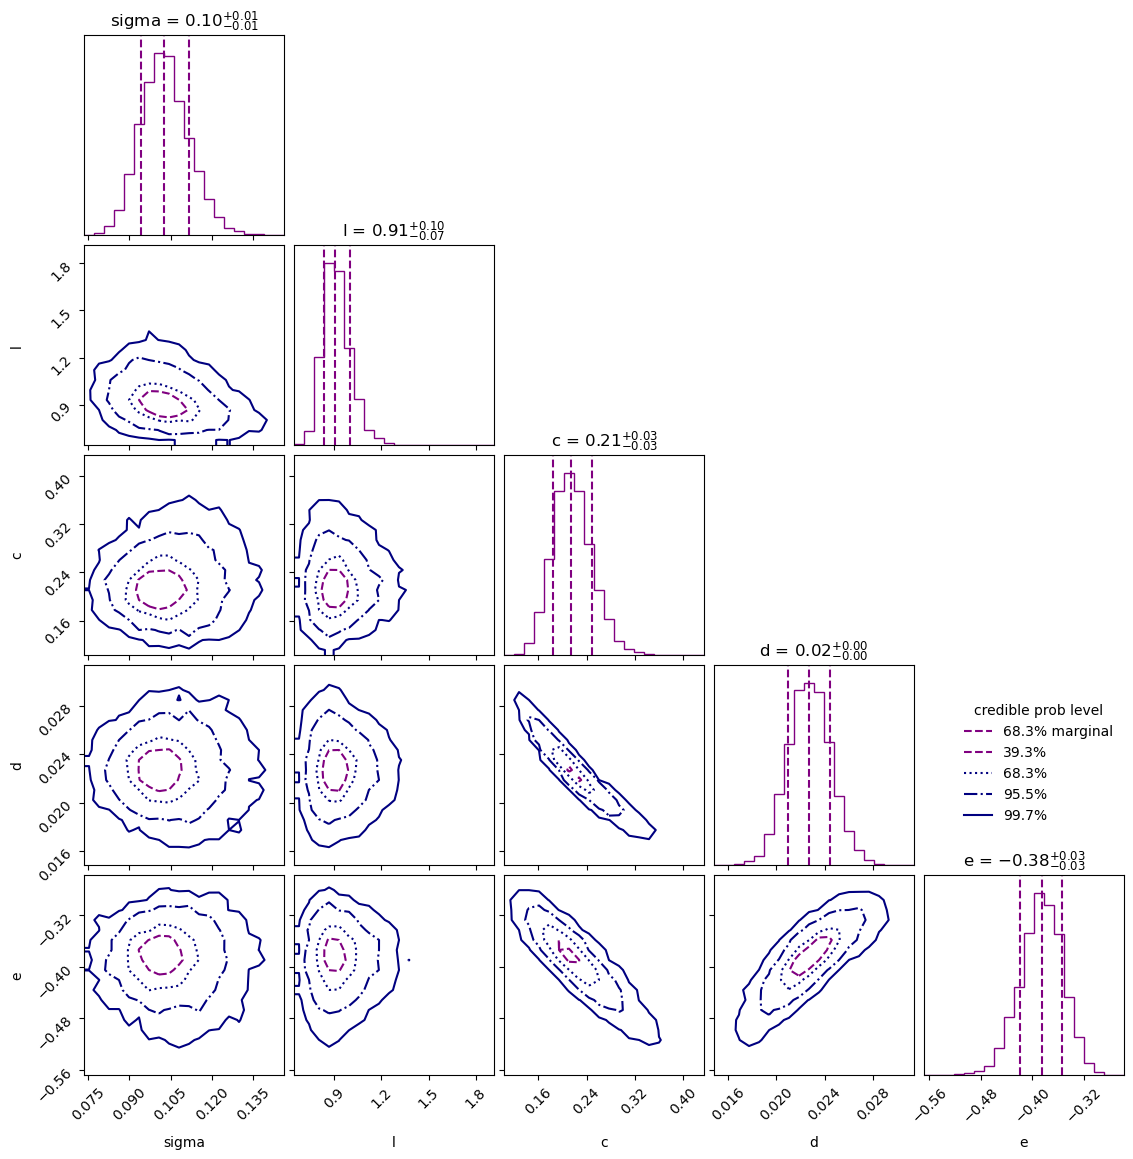

In [29]:
cornerplot(exp_GP_result, min_weight=0.001);

In [30]:
exp_sigma_samples = exp_GP_result["samples"][:, 0] 
exp_sigma_best = np.median(exp_sigma_samples)

exp_l_samples = exp_GP_result["samples"][:, 1] 
exp_l_best = np.median(exp_l_samples)

exp_c_samples = exp_GP_result["samples"][:, 2] 
exp_c_best = np.median(exp_c_samples)

exp_d_samples = exp_GP_result["samples"][:, 3] 
exp_d_best = np.median(exp_d_samples)

exp_e_samples = exp_GP_result["samples"][:, 4] 
exp_e_best = np.median(exp_e_samples)

def exp_gp_base(year): return (exp_c_best * np.exp(exp_d_best * (year - 1937)) + exp_e_best)

exp_GP_kernel = exp_sigma_best ** 2 * george.kernels.ExpSquaredKernel(1/(2 * exp_l_best ** 2)) 
exp_GP = george.GP(exp_GP_kernel)
exp_GP.compute(year, temp_err)



exp_GP_pred, exp_GP_pred_var = exp_GP.predict(temp - exp_gp_base(year), x_pred, return_var = True)
exp_GP_pred += exp_gp_base(x_pred)

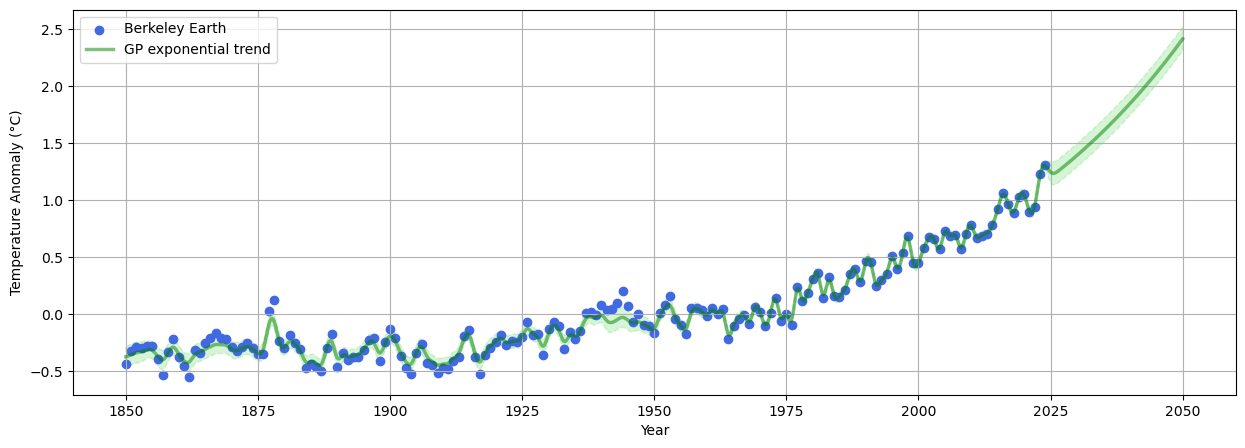

In [31]:
plt.figure(figsize=(15, 5))
# plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color = "indianred", alpha = 0.2, linestyle = "--")
plt.fill_between(x_pred, exp_GP_pred - np.sqrt(exp_GP_pred_var), exp_GP_pred + np.sqrt(exp_GP_pred_var), color = "limegreen", alpha = 0.2, linestyle = "--")

plt.scatter(year, temp, color = "royalblue", label='Berkeley Earth', linestyle= "-")
# plt.plot(x_pred, pred, color = "red", lw = 2.5, alpha = 0.5, label = 'GP zero mean')
plt.plot(x_pred, exp_GP_pred, color = "green", lw = 2.5, alpha = 0.5, label = 'GP exponential trend')
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()

### Model Comparison

Our aim is to understand which model predicts better our data $D$. To do so we use the logarithm of Bayes factor $K$, the ratio between the evidences $Z_i$ of the models $M_i$ and $M_j$ we want to compare.

$$
    \frac{Z_i}{Z_j} = \frac{\int d\theta _i P(\theta _i|M_i) P(D|\theta _i,M_i)}{\int d\theta _ j P(\theta _j|M_j) P(D|\theta _j,M_j)} \; ,
$$
where
$$
K = \ln{\left(\frac{Z_i}{Z_j}\right)} = \ln{\left(\frac{e^{\ln{Z_i}}}{e^{\ln{Z_j}}}\right)} = \left(\ln{Z_i} - \ln{Z_j}\right) \; .
$$

In [32]:
#here we use the constant temperature model as unit measure 
K_GPexp_const = exp_GP_result['logz'] - const_result['logz'] 
print("K (GPexp/const) = " , K_GPexp_const)

K_GPlin_const = lin_GP_result['logz'] - const_result['logz'] 
print("K (GPlin/const) = " , K_GPlin_const)

K_GPconst_const = const_GP_result['logz'] - const_result['logz'] 
print("K (GPconst/const) = " , K_GPconst_const)

K_exp_const = exp_result['logz'] - const_result['logz'] 
print("K (exp/const) = " , K_exp_const)

K_lin_const = lin_result['logz'] - const_result['logz'] 
print("K (lin/const) = " , K_lin_const)

K (GPexp/const) =  7082.11045491935
K (GPlin/const) =  7036.128551226439
K (GPconst/const) =  6995.1676782180775
K (exp/const) =  6819.913377671655
K (lin/const) =  5551.564918903202


In [33]:
#comparison just between GPs
K_GPexp_GPlin = exp_GP_result['logz'] - lin_GP_result['logz'] 
print("K (GPexp/GPlin) = " , K_GPexp_GPlin)

K_GPexp_GPconst = exp_GP_result['logz'] - const_GP_result['logz'] 
print("K (GPexp/GPconst) = " , K_GPexp_GPconst)

K (GPexp/GPlin) =  45.98190369291061
K (GPexp/GPconst) =  86.94277670127187


### Future Prediction

In [34]:
#########################################################################################################################################################
#                                                                      PROBLEM!                                                                         #
#           I'd like to make future predictions. I can't figure why it predicts zero temperature anomaly when it goes out of the data range.            #
#                                                                                                                                                       #
#########################################################################################################################################################

In [35]:
x_pred2 = np.linspace(1850, 2030, 5000)
pred2, pred_var2 = gp.predict(temp, x_pred2, return_var = True)
exp_GP_pred2, exp_GP_pred_var2 = exp_GP.predict(temp - exp_gp_base(year), x_pred2, return_var = True)
exp_GP_pred2 += exp_gp_base(x_pred2)

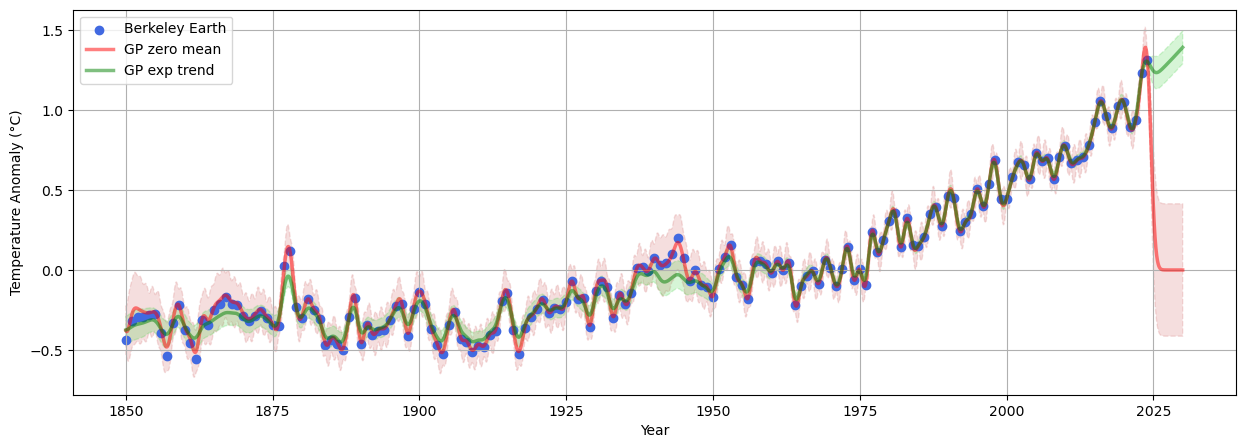

In [36]:
plt.figure(figsize=(15, 5))
plt.fill_between(x_pred2, pred2 - np.sqrt(pred_var2), pred2 + np.sqrt(pred_var2), color = "indianred", alpha = 0.2, linestyle = "--")
plt.fill_between(x_pred2, exp_GP_pred2 - np.sqrt(exp_GP_pred_var2), exp_GP_pred2 + np.sqrt(exp_GP_pred_var2), color = "limegreen", alpha = 0.2, linestyle = "--")

plt.scatter(year, temp, color = "royalblue", label='Berkeley Earth', linestyle= "-")
plt.plot(x_pred2, pred2, color = "red", lw = 2.5, alpha = 0.5, label = 'GP zero mean')
plt.plot(x_pred2, exp_GP_pred2, color = "green", lw = 2.5, alpha = 0.5, label = 'GP exp trend')
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()